In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import numpy as np
import pandas as pd
from src.bioreactor import mpc, plot_results, evaluation, generate_training_data, model_predict, simulate
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

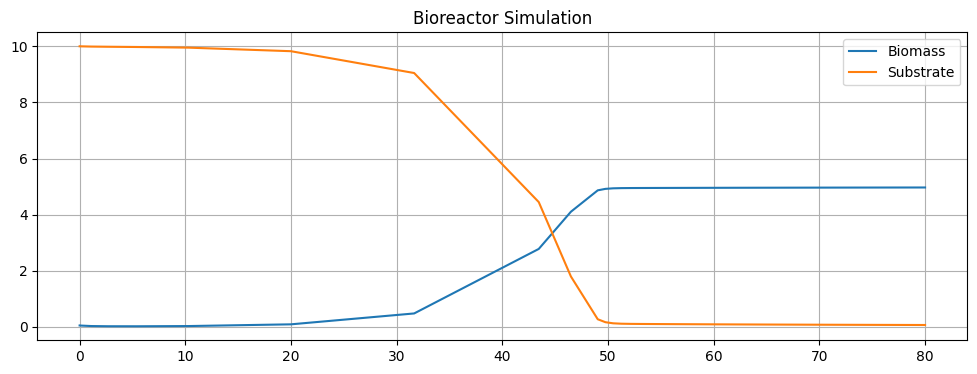

In [94]:
sol = simulate(1, plot=True)

In [75]:
X_train, y_train = generate_training_data()

In [76]:
model = MLPRegressor().fit(X_train, y_train)
model_predict(X_train[0][0], X_train[0][1], X_train[0][2], X_train[0][3], model)

array([ 0.22928044, 12.60522246,  2.67261143])

In [88]:
X, S, V, F = mpc(model='discretized')

100%|██████████| 80/80 [00:00<00:00, 102.93it/s]


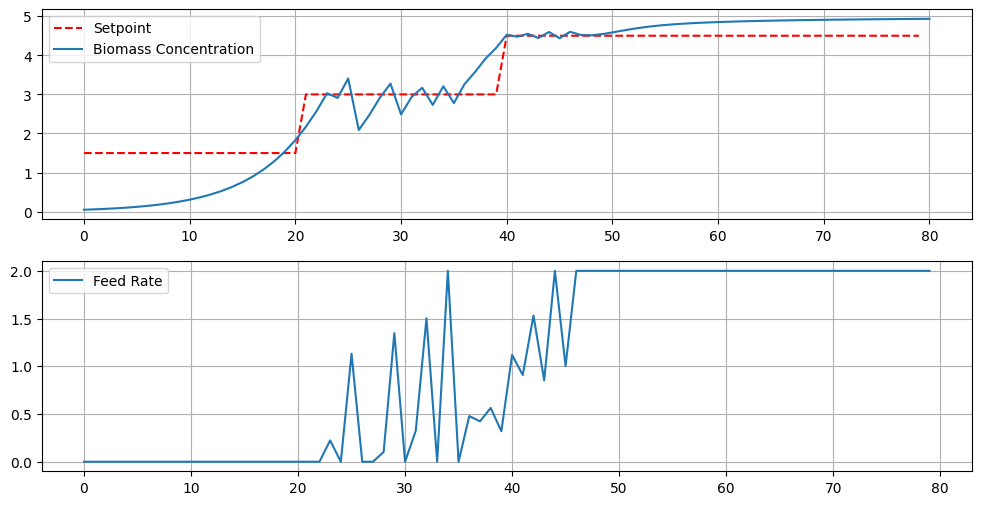

In [89]:
plot_results(X, F)

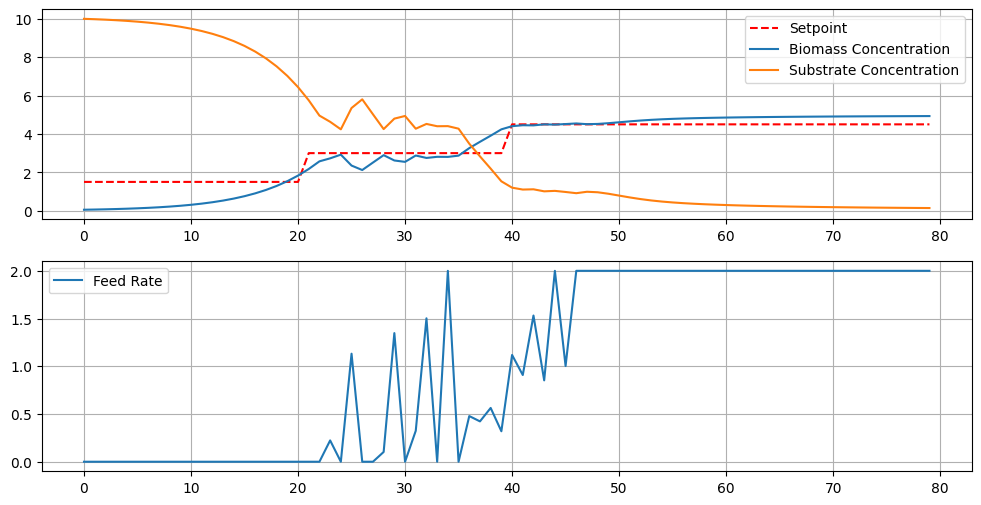

In [90]:
evaluation(F)